In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans
from utils.data_loader import CrashDataLoader 
import geopy.distance as geo_distance

In [2]:
HOSPITAL_RADIUS = 12.5

In [3]:
data_loader = CrashDataLoader()

Loading data from: 
./data/2000 to 2005 ACCIDENT
./data/ACCIDENT


In [4]:
person_df = data_loader.load_file("PERSON.csv")
person_df["inj_level"] = pd.to_numeric(person_df["inj_level"], errors="coerce")
person_df = person_df.dropna(subset=["inj_level"])
person_df["inj_level"] = person_df["inj_level"].astype('int32')
person_df.shape

C:\Work\job\blunomy\utils\data_loader.py:11: DtypeWarning: Columns (0,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(Path(folder_path) / file_name) for folder_path in self.path_list]
C:\Work\job\blunomy\utils\data_loader.py:11: DtypeWarning: Columns (6,9,10,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(Path(folder_path) / file_name) for folder_path in self.path_list]


(759976, 17)

In [50]:
accident_df = data_loader.load_file("ACCIDENT.csv")
org_hospital_distance_df = pd.read_csv("./data/NodeHospitalDistance.csv")

injury_df = person_df[["accident_no","inj_level"]].groupby(by=["accident_no"]).min()
injury_df = injury_df.join(accident_df[["accident_no","node_id"]].set_index("accident_no")).join(hospital_distance_df.set_index("node_id"), on="node_id")
injury_df = injury_df.rename(columns={"hospital_distance": "org_hospital_distance", "hospital_id": "org_hospital_id"})

C:\Work\job\blunomy\utils\data_loader.py:11: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(Path(folder_path) / file_name) for folder_path in self.path_list]
C:\Work\job\blunomy\utils\data_loader.py:11: DtypeWarning: Columns (10,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(Path(folder_path) / file_name) for folder_path in self.path_list]


In [34]:
node_df = data_loader.load_file("NODE.csv")
node_df = node_df.drop_duplicates(subset=["node_id"])
node_df["coordinate"] = list(zip(node_df.lat, node_df.long))
node_df

C:\Work\job\blunomy\utils\data_loader.py:11: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(Path(folder_path) / file_name) for folder_path in self.path_list]


,accident_no,node_id,node_type,amg_x,amg_y,lga_name,region name,deg urban name,lat,long,postcode no,vicgrid94_x,vicgrid94_y,lga_name_all,region_name,deg_urban_name,postcode_no,coordinate
0,12000000389,25264,N,2512514.427,2388780.839,DANDENONG,METROPOLITAN SOUTH EAST REGION,Metropolitan Excluding CBD,-38.002110,145.142480,3173.0,NaN,NaN,NaN,NaN,NaN,NaN,"(-38.00211, 145.14248)"
1,12000000554,42800,I,2506548.994,2392856.260,KINGSTON,METROPOLITAN SOUTH EAST REGION,Metropolitan Excluding CBD,-37.965450,145.074530,3192.0,NaN,NaN,NaN,NaN,NaN,NaN,"(-37.96545, 145.07453)"
2,12000000555,40101,I,2498299.136,2404214.048,PORT PHILLIP,METROPOLITAN NORTH WEST REGION,Metropolitan Excluding CBD,-37.863140,144.980670,3182.0,NaN,NaN,NaN,NaN,NaN,NaN,"(-37.86314, 144.98067)"
3,12000000559,127638,N,2500115.047,2395234.944,BAYSIDE,METROPOLITAN SOUTH EAST REGION,Metropolitan Excluding CBD,-37.944040,145.001310,3188.0,NaN,NaN,NaN,NaN,NaN,NaN,"(-37.94404, 145.00131)"
4,12000000586,57539,I,2505935.803,2401836.040,STONNINGTON,METROPOLITAN SOUTH EAST REGION,Metropolitan Excluding CBD,-37.884550,145.067480,3145.0,NaN,NaN,NaN,NaN,NaN,NaN,"(-37.88455, 145.06748)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326407,T20090046284,229107,N,NaN,NaN,WHITTLESEA,NaN,NaN,-37.676468,145.050491,NaN,2504453.781,2424931.347,WHITTLESEA,METROPOLITAN NORTH WEST REGION,MELB_URBAN,3082.0,"(-37.67646811, 145.0504909)"
326408,T20090046106,229103,N,NaN,NaN,WHITTLESEA,NaN,NaN,-37.645401,144.991064,NaN,2499211.462,2428380.388,WHITTLESEA,METROPOLITAN NORTH WEST REGION,MELB_URBAN,3076.0,"(-37.64540054, 144.9910643)"
326410,T20090047746,229114,N,NaN,NaN,BOROONDARA,NaN,NaN,-37.791877,145.093559,NaN,2508240.178,2412119.954,BOROONDARA,METROPOLITAN SOUTH EAST REGION,MELB_URBAN,3104.0,"(-37.79187719, 145.0935586)"
326411,T20090044445,229087,N,NaN,NaN,INDIGO,NaN,NaN,-36.092861,146.702041,NaN,2653269.886,2599283.209,INDIGO,NORTH EASTERN REGION,RURAL_VICTORIA,3688.0,"(-36.09286128, 146.7020407)"


In [8]:
def get_min_hospital_distance(row, hospital_df):
    hospital_id_list = list(hospital_df["hospital id"])
    hospital_coor_list = list(hospital_df["coordinate"])
    
    min_distance, min_hospital_id = None, -1

    try:
        for h_id,h_coor in zip(hospital_id_list, hospital_coor_list):
            _distance = geo_distance.distance(row["coordinate"],h_coor).km
            if min_distance is None or _distance < min_distance:
                min_hospital_id = h_id
                min_distance = _distance
        return min_hospital_id, min_distance
    except:
        return -1, -1

In [21]:
crash_coor_df = accident_df.join(node_df[["accident_no","lat","long"]].set_index("accident_no"), on="accident_no")[["accident_no","lat","long"]].dropna()
crash_coor_df = injury_df.join(crash_coor_df.set_index("accident_no")).dropna()
crash_coor_df

,inj_level,node_id,hospital_id,org_hospital_distance,lat,long
accident_no,,,,,,
12000000389,1,25264.0,3405.0,7.315271,-38.002110,145.142480
12000000554,2,42800.0,3425.0,5.015673,-37.965450,145.074530
12000000555,2,40101.0,10636.0,1.894277,-37.863140,144.980670
12000000559,2,127638.0,3425.0,2.375678,-37.944040,145.001310
12000000586,3,57539.0,3390.0,6.359619,-37.884550,145.067480
...,...,...,...,...,...,...
T20200018987,2,665599.0,3405.0,2.463386,-37.998038,145.212482
T20200019125,2,665832.0,12280.0,7.119641,-38.032257,145.268088
T20200019239,2,665835.0,2447.0,1.492807,-37.828081,144.983214


array([[143.18939435, -37.1183002 ],
       [145.58237574, -37.49367767]])

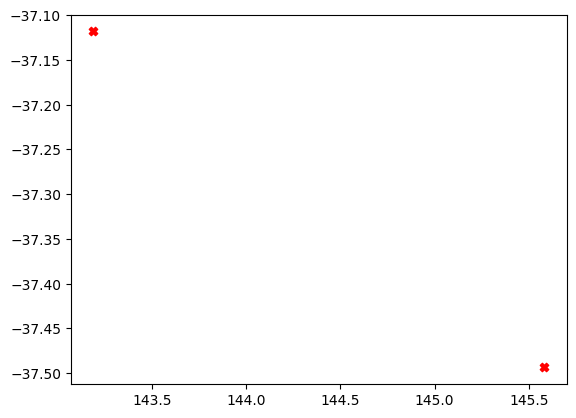

In [26]:
n_recommendations = 2

kmeans = KMeans(n_clusters=n_recommendations, n_init=10, random_state=0).fit(crash_coor_df[crash_coor_df["org_hospital_distance"]>HOSPITAL_RADIUS][["long", "lat"]])
display(kmeans.cluster_centers_)
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], c="r", marker="X")
plt.show()

# Save new sites recommendations
new_hospital_df = pd.DataFrame()
new_hospital_df["coordinate"] = [tuple(coor_pair) for coor_pair in kmeans.cluster_centers_[:,::-1]]
new_hospital_df["hospital id"] = range(1, len(new_hospital_df)+1)
new_hospital_df["hospital id"] = new_hospital_df["hospital id"]*-1
new_hospital_df
new_hospital_df.to_csv("./data/HospitalRecommendation/RecommendHospitalList_kmeans_{}.csv".format(n_recommendations), index=False)

In [66]:
tqdm.pandas(desc='Calculating distance to ER')
new_hospital_distance_df = org_hospital_distance_df
new_hospital_distance_df = new_hospital_distance_df.rename(columns={"hospital_distance": "org_hospital_distance", "hospital_id": "org_hospital_id"})

new_node_df = node_df
new_node_df[["new_hospital_id","new_hospital_distance"]] = new_node_df.progress_apply(lambda row: get_min_hospital_distance(row, hospital_df = new_hospital_df), axis=1, result_type="expand")
new_hospital_distance_df = new_hospital_distance_df.join(new_node_df[["node_id","new_hospital_id","new_hospital_distance"]].set_index("node_id"), on="node_id")

# Compare and keep min hospital distance
def get_min_hospital(row):
    if row["new_hospital_distance"]<row["org_hospital_distance"]:
        return row["new_hospital_id"], row["new_hospital_distance"]
    else:
        return row["org_hospital_id"], row["org_hospital_distance"]

tqdm.pandas(desc='Selecting min distance hospital')
new_hospital_distance_df[["hospital_id", "hospital_distance"]] = new_hospital_distance_df.apply(lambda row:get_min_hospital(row), axis=1, result_type="expand")
# new_hospital_distance_df["hospital_id"] = new_hospital_distance_df["hospital_id"].astype("int64")

Calculating distance to ER: 100%|████████████████████████████████████████████| 192756/192756 [01:08<00:00, 2797.76it/s]


In [67]:
new_injury_df = injury_df.join(new_hospital_distance_df[["node_id","hospital_id","hospital_distance"]].set_index("node_id"), on="node_id")


# new_injury_df[["hospital_id", "hospital_distance"]] = new_injury_df.apply(lambda row:get_min_hospital(row), axis=1, result_type="expand")
# new_injury_df["hospital_distance"] = new_injury_df[["org_hospital_distance","new_hospital_distance"]].min(axis=1)
print("Crashes that have reduced distance: {}".format(sum(new_injury_df["hospital_distance"] != new_injury_df["org_hospital_distance"])))

Crashes that have reduced distance: 12459


array([[145.46337558, -38.31700491],
       [142.97538627, -37.12799999],
       [147.49827937, -37.72272501],
       [144.58152801, -37.55736013],
       [145.36779062, -36.24392081],
       [141.61477993, -38.00433095],
       [142.06837213, -34.34096323],
       [146.31715578, -38.2099109 ],
       [143.68647181, -38.4823063 ],
       [146.95988753, -36.46053582],
       [145.51876583, -37.69098355],
       [144.15065354, -36.21104383],
       [143.98984261, -37.24318079],
       [148.83711875, -37.53764106],
       [142.83709882, -38.2683861 ],
       [146.00292391, -36.91221649],
       [141.98773043, -36.60640997],
       [142.98793877, -35.26096764],
       [145.05547048, -37.22175617],
       [144.34760315, -38.15458081]])

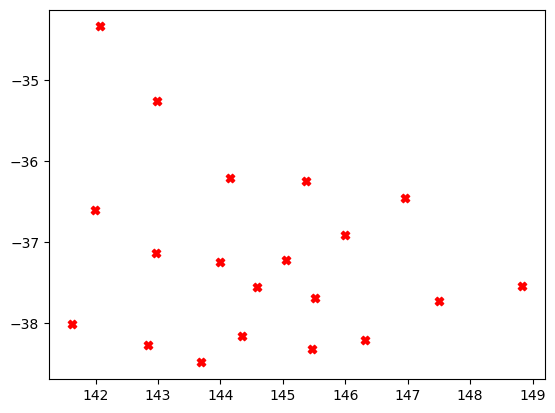

Calculating distance to ER:  74%|█████████████████████████████████▏           | 142084/192756 [07:30<02:38, 320.10it/s]

In [ ]:
# for n_recommendations in range(1,11):
for n_recommendations in [20,30,40,50]:
    # Find new sites with kmeans
    kmeans = KMeans(n_clusters=n_recommendations, n_init=10, random_state=0).fit(crash_coor_df[crash_coor_df["org_hospital_distance"]>HOSPITAL_RADIUS][["long", "lat"]])
    display(kmeans.cluster_centers_)
    plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], c="r", marker="X")
    plt.show()
    
    # Save new sites recommendations
    new_hospital_df = pd.DataFrame()
    new_hospital_df["coordinate"] = [tuple(coor_pair) for coor_pair in kmeans.cluster_centers_[:,::-1]]
    new_hospital_df["hospital id"] = range(1, len(new_hospital_df)+1)
    new_hospital_df["hospital id"] = new_hospital_df["hospital id"]*-1
    new_hospital_df.to_csv("./data/HospitalRecommendation/RecommendHospitalList_kmeans_{}.csv".format(n_recommendations), index=False)

    # Calculate node distance to ER
    new_hospital_distance_df = org_hospital_distance_df
    new_hospital_distance_df = new_hospital_distance_df.rename(columns={"hospital_distance": "org_hospital_distance", "hospital_id": "org_hospital_id"})
    new_node_df = node_df
    
    tqdm.pandas(desc='Calculating distance to ER')
    new_node_df[["new_hospital_id","new_hospital_distance"]] = new_node_df.progress_apply(lambda row: get_min_hospital_distance(row, hospital_df = new_hospital_df), axis=1, result_type="expand")
    new_hospital_distance_df = new_hospital_distance_df.join(new_node_df[["node_id","new_hospital_id","new_hospital_distance"]].set_index("node_id"), on="node_id")
    # Compare and keep min hospital distance    
    tqdm.pandas(desc='Selecting min distance hospital')
    new_hospital_distance_df[["hospital_id", "hospital_distance"]] = new_hospital_distance_df.apply(lambda row:get_min_hospital(row), axis=1, result_type="expand")
    new_hospital_distance_df["hospital_id"] = new_hospital_distance_df["hospital_id"].astype("int64")

    # Save new hospital distance
    new_hospital_distance_df[["node_id", "hospital_id", "hospital_distance"]] .to_csv("./data/HospitalRecommendation/NodeHospitalDistance_kmeans_{}.csv".format(n_recommendations), index=False)

    
    # See impact of new chosen sites
    new_injury_df = injury_df.join(new_hospital_distance_df[["node_id","hospital_id","hospital_distance"]].set_index("node_id"), on="node_id")
    print("Crashes that have reduced distance: {}".format(sum(new_injury_df["hospital_distance"] != new_injury_df["org_hospital_distance"])))

In [73]:
new_injury_df[new_injury_df["hospital_id"]<0]

,inj_level,node_id,org_hospital_id,org_hospital_distance,hospital_id,hospital_distance
accident_no,,,,,,
22000001269,1,181276.0,10567.0,156.696866,-6.0,116.641318
22000001915,3,149942.0,10441.0,57.616845,-10.0,50.102869
22000002348,3,127364.0,10582.0,22.925746,-5.0,6.727905
22000002385,2,52673.0,10567.0,100.277551,-6.0,67.746453
22000002525,3,44852.0,7783.0,57.725527,-2.0,48.396829
...,...,...,...,...,...,...
T20200018198,2,665804.0,6802.0,87.092883,-3.0,46.824300
T20200018321,2,664666.0,10582.0,43.918759,-5.0,23.946752
T20200018398,2,665036.0,6802.0,87.803801,-3.0,73.023077


In [74]:
new_injury_df

,inj_level,node_id,org_hospital_id,org_hospital_distance,hospital_id,hospital_distance
accident_no,,,,,,
12000000389,1,25264.0,3405.0,7.315271,3405.0,7.315271
12000000554,2,42800.0,3425.0,5.015673,3425.0,5.015673
12000000555,2,40101.0,10636.0,1.894277,10636.0,1.894277
12000000559,2,127638.0,3425.0,2.375678,3425.0,2.375678
12000000586,3,57539.0,3390.0,6.359619,3390.0,6.359619
...,...,...,...,...,...,...
T20200019239,2,665835.0,2447.0,1.492807,2447.0,1.492807
T20200019247,2,665912.0,10441.0,9.730209,10441.0,9.730209
T20200019250,2,226603.0,10214.0,5.778805,10214.0,5.778805
